In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os

import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv1D, LeakyReLU, BatchNormalization, AveragePooling1D, MaxPooling1D
from keras.layers import LSTM

import matplotlib.pyplot as plt

from contextlib import redirect_stdout

Using TensorFlow backend.


In [0]:
# paths
directory = "drive/My Drive/UE_Proell"
preprocessed = f"{directory}/preprocessed"
result = f"{directory}/result"

# hyper parameter
loss = 'categorical_crossentropy'
learning_rate = 0.001
leaky_alpha = 0.01
dropout = 0.5
batch_size = 5
epochs = 100

# configuration parameter
validation_split = 0.2
seed = 42
patience = 20

# others
model_name = "urbaner"
input_shapes = {
    "dnn": (40, ),
    "cnn": (40, 1)
}

In [4]:
os.makedirs(result, exist_ok=True)

X_train, y_train = np.load(f"{preprocessed}/X_train.npy"), np.load(f"{preprocessed}/y_train.npy")
X_test, y_test = np.load(f"{preprocessed}/X_test.npy"), np.load(f"{preprocessed}/y_test.npy")

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_split, random_state=seed, stratify=y_train)

num_of_labels = y_train.shape[1]

print("X_train", X_train.shape, "-", "y_train", y_train.shape)
print("X_valid", X_valid.shape, "-", "y_valid", y_valid.shape)
print("X_test", X_test.shape, "-", "y_test", y_test.shape)

X_train (2909, 40) - y_train (2909, 10)
X_valid (728, 40) - y_valid (728, 10)
X_test (33, 40) - y_test (33, 10)


In [0]:
def getDNN(input_shape):
  model = Sequential()

  model.add(Dense(1024, input_shape=input_shape, activation='relu'))
  model.add(Dropout(dropout))

  #model.add(Dense(128, activation='relu'))
  #model.add(Dropout(dropout))

  model.add(Dense(num_of_labels, activation='softmax'))
  return model

In [0]:
def getCNN(input_shape):
    model = Sequential()
    model.add(Conv1D(filters = 1, kernel_size = 7, input_shape=input_shape))
    model.add(LeakyReLU(alpha = leaky_alpha))
    model.add(BatchNormalization())

    #model.add(Conv1D(filters = 16, kernel_size = 5))
    #model.add(LeakyReLU(alpha = leaky_alpha))
    #model.add(MaxPooling1D(2, strides = 2))

    #model.add(Conv1D(filters = 32, kernel_size = 3))
    #model.add(LeakyReLU(alpha = leaky_alpha))
    #model.add(AveragePooling1D(2, strides = 2))

    model.add(Flatten())

    #model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(128, activation='relu'))

    model.add(Dense(num_of_labels, activation='softmax'))
    return model

In [0]:
def getLSTM(input_shape):
  model = Sequential()
  model.add(LSTM(300, input_shape=input_shape, return_sequences=True))
  model.add(Dropout(dropout))

  model.add(LSTM(300))
  model.add(Dropout(dropout))

  model.add(Dense(num_of_labels, activation='softmax'))
  return model

In [0]:
networks = {
    "dnn": getDNN,
    "cnn": getCNN,
    #"lstm": getLSTM,
}

def learning_rate_scheduler(epoch, learning_rate):
    decay_rate = 0.1
    decay_step = 50
    if epoch % decay_step == 0 and epoch:
        return learning_rate * decay_rate
        
    return learning_rate

In [0]:
def save_model_information(network, input_shape, hist, scores):
  result_path = f"{result}/{network}"
  if not os.path.exists(result_path):
    os.makedirs(result_path)

  model.save(f"{result_path}/{model_name}")

  # plot history for accuracy
  plt.figure()
  plt.ioff()
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.savefig(f"{result_path}/accuracy_{model_name}")

  # plot history for loss
  plt.figure()
  plt.ioff()
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.savefig(f"{result_path}/loss_{model_name}")

  #save detail information
  with open(f"{result_path}/{model_name}.txt","w+") as f:
      f.write('Trainingparameter:\n')
      f.write('ValidationSplit: {0}\n'.format(validation_split))
      f.write('Batchsize: {0}\n'.format(batch_size))
      f.write('Epochs: {0}\n'.format(epochs))
      f.write('Patience for Early Stopping: {0}\n'.format(patience))
      f.write('Inputdimension: ({0})\n'.format(input_shape))
      f.write('\n')
      f.write('Results:\n')
      f.write('Trainingaccuracy: {0}\n'.format(hist.history['acc'][-1]*100))
      f.write('Testaccuracy: {0}\n'.format(scores[1] * 100))
      f.write('\n')
      f.write('Modelarchitecture:\n')
      with redirect_stdout(f):
          model.summary()

[dnn] Train network




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2909 samples, validate on 728 samples
Epoch 1/100





2909/2909 [==============================] - 2s 679us/step - loss: 11.4185 - acc: 0.2396 - val_loss: 10.2920 - val_acc: 0.3091
Epoch 2/100
2909/2909 [==============================] - 1s 365us/step - loss: 10.6932 - acc: 0.2998 - val_loss: 10.6922 - val_acc: 0.2995
Epoch 3/100
2909/2909 [==============================] - 1s 355us/step - loss: 10.0011 - acc: 0.3393 - val_loss: 9.1963 - val_acc: 0.3929
Epoch 4/100
2909/2909 [==============================] - 1s 359us/step - loss: 9.5936 - acc: 0.3730 - val_loss: 9.2693 - val_acc: 0.3942
Epoch 5/100
2909/2909 [==============================] - 1s 358us/step - loss: 9.5394 - acc: 0.3771 - val_loss: 9.4369 - val_acc: 0.3832
Epoch 6/100
2909/290

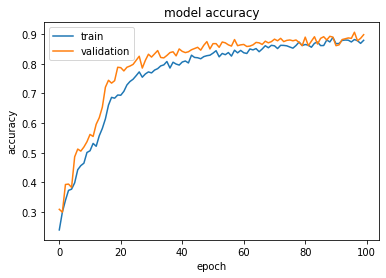

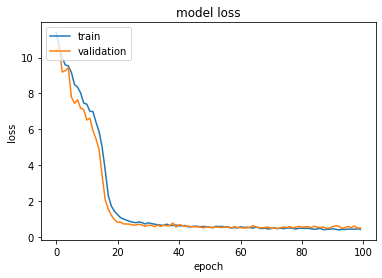

In [10]:
for network in list(networks.keys())[:1]:
  print(f"[{network}] Train network")
  input_shape = input_shapes[network]

  model = networks[network](input_shape)
  model.compile(Adam(lr=learning_rate), loss=loss, metrics=['accuracy'])

  callbacks = [
        EarlyStopping(monitor="loss", patience=patience, verbose=0, mode="auto"),
        #LearningRateScheduler(learning_rate_scheduler, verbose=0)
  ]
  
  X = {
      "train": X_train.copy(),
      "test": X_test.copy(),
      "valid": X_valid.copy()
  }

  if network == "cnn":
    X["train"] = np.expand_dims(X["train"], axis=2)
    X["test"] = np.expand_dims(X["test"], axis=2)
    X["valid"] = np.expand_dims(X["valid"], axis=2)

  hist = model.fit(X["train"], y_train, validation_data=(X["valid"], y_valid), batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1, callbacks=callbacks)
  scores = model.evaluate(X["test"], y_test, verbose=0)

  print(f"[{network}] Testaccuracy {scores[1] * 100}")
  save_model_information(network, input_shape, hist, scores)